In [2]:
from smt.sampling_methods import LHS
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm.notebook  import tqdm
from loguru import logger
import multiprocessing as mp
from netCDF4 import Dataset
import pandas as pd

# set parameter ranges

In [55]:
para_limits = np.array([
    [0.01,1.4],
    [1.02E20, 1.67e24]
]
)

para_default = [0.1,1.15e23]

num = 1000

base_path="/home/tzhang/wrf_solar/wsolar412_bnl/"
archive_path = "/S2/gscr2/tzhang/big_data/UQ/sampling/"
para_names = ['vdis','beta_con']

In [3]:
sampling = LHS(xlimits=para_limits)
x = sampling(num)
print(x.shape)
print(x[0,:])

(1000, 2)
[1.18663500e+00 7.07303803e+23]


In [4]:
para_samples = []
for id, xx in enumerate(x):
    samp = {}
    for i,name in enumerate(para_names):
        samp[name] = xx[i]
    para_samples.append((id,samp))
    

In [5]:
para_samples[0]

(0, {'vdis': 1.1866349999999999, 'beta_con': 7.073038029999999e+23})

Text(0, 0.5, 'y')

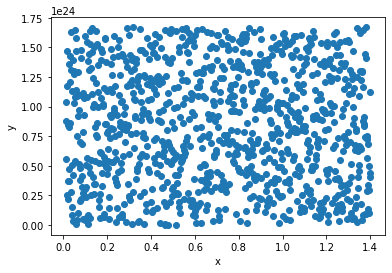

In [6]:
plt.plot(x[:, 0], x[:, 1], "o")
plt.xlabel("x")
plt.ylabel("y")

In [4]:
def run_case(id,x):
    #create a case
    #print("cp -r "+base_path+"/runwrf "+base_path+"/case"+str(id))
    os.system("cp -r "+base_path+"/runwrf "+base_path+"/case"+str(id))
    os.chdir(base_path+"/case"+str(id))
    logger.add("case"+str(id)+".log")
    logger.info("case"+str(id)+": create a case")
    logger.info("case"+str(id)+": "+str(x))
    #os.system("touch a")
    
    # modify runwrf.sh
    logger.info("case"+str(id)+": modifiy runwrf.sh")
    os.system("sed -i 's/runwrf/case0/g' runwrf.sh")
    
    # modify namelist
    logger.info("case"+str(id)+": modifiy namelist")
    for key in x:
        replace_str = "sed -i '/^ "+key+"/c\ "+key+"="+str(x[key])+"' namelist.input"
        os.system(replace_str)
    
    # run model
    logger.info("case"+str(id)+": run model")
    time.sleep(30)
    #jid = os.popen("qsub runwrf.sh").read().split('.')[0]
    #print(jid)
    #while os.popen("qstat").read().find(jid) != -1:
    #    time.sleep(300)
        
    #archive case
    logger.info("case"+str(id)+": archive case")
    os.chdir(base_path)
    #print("mv case"+str(id)+" "+archive_path)
    os.system("mv case"+str(id)+" "+archive_path) 
    
    logger.info("case"+str(id)+": success!!!")
    logger.remove()
    
def run_case_wrapper(args):
    return run_case(*args)
    

In [26]:
pool = mp.Pool(10)
pool.map(run_case_wrapper,para_samples[:10])

2021-02-17 15:03:24.226 | INFO     | __main__:run_case:7 - case0: create a case
2021-02-17 15:03:24.231 | INFO     | __main__:run_case:8 - case0: {'vdis': 1.1866349999999999, 'beta_con': 7.073038029999999e+23}
2021-02-17 15:03:24.232 | INFO     | __main__:run_case:12 - case0: modifiy runwrf.sh
2021-02-17 15:03:25.585 | INFO     | __main__:run_case:16 - case0: modifiy namelist
2021-02-17 15:03:28.341 | INFO     | __main__:run_case:22 - case0: run model
2021-02-17 15:03:58.374 | INFO     | __main__:run_case:30 - case0: archive case
2021-02-17 15:04:07.314 | INFO     | __main__:run_case:35 - case0: success!!!
2021-02-17 15:05:25.044 | INFO     | __main__:run_case:7 - case4: create a case
2021-02-17 15:05:25.047 | INFO     | __main__:run_case:8 - case4: {'vdis': 0.8516449999999999, 'beta_con': 2.28043077e+23}
2021-02-17 15:05:25.048 | INFO     | __main__:run_case:12 - case4: modifiy runwrf.sh
2021-02-17 15:05:25.827 | INFO     | __main__:run_case:16 - case4: modifiy namelist
2021-02-17 15:

[None, None, None, None, None, None, None, None, None, None]

# calc metrics

In [76]:
def calc_metrics(path_mod):
    var_list = ['dni','dhi'] # dni: direct normal irradiance DHI: diffuse horizontal irradiance
    varn_obs = ['obs_swddni', 'obs_swddif']
    varn_mod = ['SWDDNI','SWDDIF']
    
    path_base = "/ss/hsdc/home/tzhang/wrf_solar/"
    path_obs = path_base+"sgpradflux10long_area_mean.c1.20160619_1200UTC.nc"
    path_def = "/S2/gscr2/tzhang/big_data/UQ/tune/runwrf_def/wrfout_d02_2016-06-19_06:00:00"
    
    fid_obs = Dataset(path_obs)
    fid_def = Dataset(path_def)
    fid_mod = Dataset(path_mod)
    
    Chi = 0
    for i, var in enumerate(var_list):
        #print(var)
        
        var_obs = fid_obs.variables[varn_obs[i]][:]
        var_mod = fid_mod.variables[varn_mod[i]][36:]
        var_def = fid_def.variables[varn_mod[i]][36:]
        
        var_mod_avg = np.mean(var_mod, axis=(1,2))
        var_def_avg = np.mean(var_def, axis=(1,2))
        
        #print(var_obs.shape)
        #print(var_mod_avg.shape)
        #print(var_def_avg.shape)
        
        theta_mod = 0
        for j in range(var_obs.shape[0]):
            theta_mod += (var_obs[j] - var_mod_avg[j]) ** 2
            
        theta_def = 0
        for j in range(var_obs.shape[0]):
            theta_def += (var_obs[j] - var_def_avg[j]) ** 2
            
        Chi += (theta_mod / theta_def)
        
    Chi /= len(var_list)
    
    return Chi, np.mean(fid_mod.variables['SWDDNI']), np.mean(fid_mod.variables['SWDDIF'])
            
all_cases = os.listdir("/S2/gscr2/tzhang/big_data/UQ/tune")
for idx in range(12):
    print(str(idx)+": ",calc_metrics("/S2/gscr2/tzhang/big_data/UQ/tune/Iter"+str(idx)+"/wrfout_d02_2016-06-19_06:00:00")[0])

print(str(13)+": ",calc_metrics("/S2/gscr2/tzhang/big_data/UQ/tune/Iter"+str(13)+"/wrfout_d02_2016-06-19_06:00:00")[0])
print(str(14)+": ",calc_metrics("/S2/gscr2/tzhang/big_data/UQ/tune/Iter"+str(14)+"/wrfout_d02_2016-06-19_06:00:00")[0])
print(str(16)+": ",calc_metrics("/S2/gscr2/tzhang/big_data/UQ/tune/Iter"+str(16)+"/wrfout_d02_2016-06-19_06:00:00")[0])
for idx in range(16,70):
    print(str(idx)+": ",calc_metrics("/S2/gscr2/tzhang/big_data/UQ/tune/Iter"+str(idx)+"/wrfout_d02_2016-06-19_06:00:00")[0])




0:  0.8086014250448218
1:  0.8415257825689977
2:  0.8466482503061028
3:  0.9190987950053155
4:  0.8412276981336335
5:  0.9770383323115949
6:  1.0764576022688366
7:  0.9262690184475022
8:  0.8138767655338754
9:  0.8647407965094136
10:  0.9482645280095798
11:  0.9213464111101468
13:  1.0014244807919868
14:  0.9776943639401492
16:  14.883599103894632
16:  14.883599103894632
17:  17.21416105796571
18:  0.8823314020866967
19:  0.8538337565257983
20:  1.0515511904093393
21:  0.966339808164346
22:  0.9746878636525915
23:  1.0261412778892156
24:  0.9048487747007476
25:  0.8401766704352442
26:  0.9898694017711764
27:  1.0346477480081517
28:  0.9232145155545632
29:  0.8989215101625021
30:  0.9811308356965073
31:  1.0187012059249891
32:  1.1065825662714153
33:  0.9028228418039647
34:  0.9480436378744888
35:  0.9909354417225318
36:  0.8592205479804562
37:  0.995015089788442
38:  0.9428757519454265
39:  0.9871057574793141
40:  0.9726987110896652
41:  0.9172147659083205
42:  0.8887159347281633
43:  

FileNotFoundError: [Errno 2] No such file or directory: b'/S2/gscr2/tzhang/big_data/UQ/tune/Iter66/wrfout_d02_2016-06-19_06:00:00'

In [77]:
for idx in range(40):
    print(str(idx)+": ",calc_metrics("/S2/gscr2/tzhang/big_data/UQ/tune1/Iter"+str(idx)+"/wrfout_d02_2016-06-19_06:00:00")[0])

0:  0.7185683910695972
1:  0.7805678499652386
2:  0.7821531804273437
3:  0.8504605079401721
4:  1.0042508507133512
5:  0.925031869219805
6:  0.848375612125577
7:  0.8728998694508294
8:  1.0806361860039104
9:  0.9432784633507407
10:  0.9504140385306361
11:  1.0117210353947745
12:  0.8810180957652385
13:  0.8956986393330012
14:  0.9489207459762283
15:  0.9411051700766202
16:  1.0333822643238508
17:  0.841220221635363
18:  0.9005196385093224
19:  0.8881447145534493
20:  0.9122269749589753
21:  0.9745002083164425
22:  0.9149974886788799
23:  0.9132285962244576
24:  0.9753657490884724
25:  0.8922588369785602
26:  0.9118109384606122
27:  0.9931460093242079
28:  0.866557082311658
29:  0.8576281169734101
30:  0.9325019997145161
31:  0.928613877108576
32:  1.0097197136148928
33:  0.9415594869579369
34:  0.8494688071224851
35:  0.8502672366064125
36:  0.881562063168485
37:  0.9144325408200031


FileNotFoundError: [Errno 2] No such file or directory: b'/S2/gscr2/tzhang/big_data/UQ/tune1/Iter38/wrfout_d02_2016-06-19_06:00:00'

# sensitive analysis

In [32]:
all_cases = os.listdir("/S2/gscr2/tzhang/big_data/UQ/tune/")
all_cases_data = pd.DataFrame(columns=['vdis','beta_con','DNI','DIF','mcpi'])

for case in all_cases:
    fp = open("/S2/gscr2/tzhang/big_data/UQ/tune/"+case+"/namelist.input")
    for i, line in enumerate(fp):
        if i == 85:
            vdis = float(line.split('=')[1])
        if i == 87:
            beta_con = float(line.split('=')[1])
    fp.close() 
        
    mcpi,DNI,DIF = calc_metrics("/S2/gscr2/tzhang/big_data/UQ/tune/"+case+"/wrfout_d02_2016-06-19_06:00:00")
    all_cases_data = all_cases_data.append({'vdis':vdis,'beta_con':beta_con,'DNI':DNI,'DIF':DIF,'mcpi':mcpi},ignore_index=True)

In [71]:
all_cases_data.iloc[50:58]

,vdis,beta_con,DNI,DIF,mcpi
53,1.304883,1.140486e+24,291.8988,124.75823,0.840177
54,1.311775,1.127873e+24,294.813,123.93753,0.979251
55,1.311842,1.127925e+24,290.54355,125.74615,0.773193
56,1.311387,9.511089e+23,294.7542,124.30432,0.921346
57,1.310439,1.124906e+24,296.2805,124.15454,0.990935
58,1.322057,1.131693e+24,298.32654,124.02765,0.966340
59,1.325613,1.191887e+24,294.4487,124.28751,0.853834
60,1.311870,1.128222e+24,293.45642,125.151085,0.865139


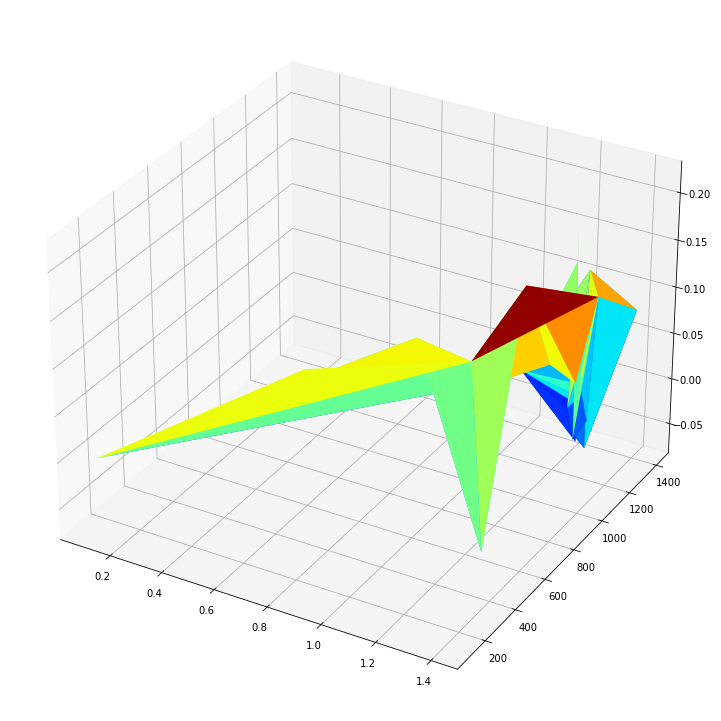

In [36]:
all_cases_data = all_cases_data[all_cases_data.mcpi<1.1]

from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,13))

surf = ax.plot_trisurf(all_cases_data['vdis'],all_cases_data['beta_con']/10e20,1-all_cases_data['mcpi'],cmap=cm.jet)

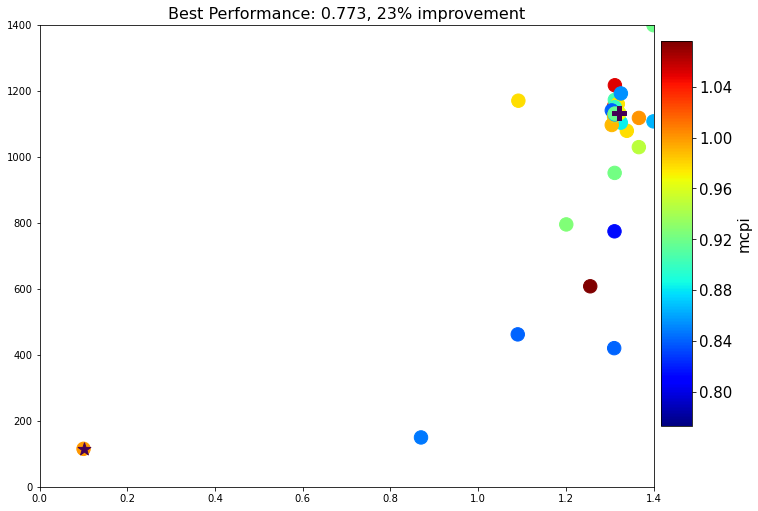

In [74]:
fh=16
fig, axes = plt.subplots(1,1,figsize=(11,8.5),squeeze=False)
aa = axes[0][0].scatter(all_cases_data['vdis'],all_cases_data['beta_con']/10e20,c=all_cases_data['mcpi'],s=180,cmap=cm.jet)
add_common_colorbar(fig,aa,list(axes[0]),"mcpi",orientation='vertical',nbins=9,fontsize=15)
axes[0][0].set_title("Best Performance: 0.773, 23% improvement",fontsize=fh)
axes[0][0].set_xlim([0,1.4])
axes[0][0].set_ylim([0,1400])
axes[0][0].scatter(para_default[0],para_default[1]/10e20,c=1.0,marker='*',s=180)
axes[0][0].scatter(all_cases_data.iloc[55,0],all_cases_data.iloc[55,1]/10e20,c=0.77,marker='P',s=180)
plt.savefig("tuning performance.pdf")

<Figure size 1152x648 with 0 Axes>

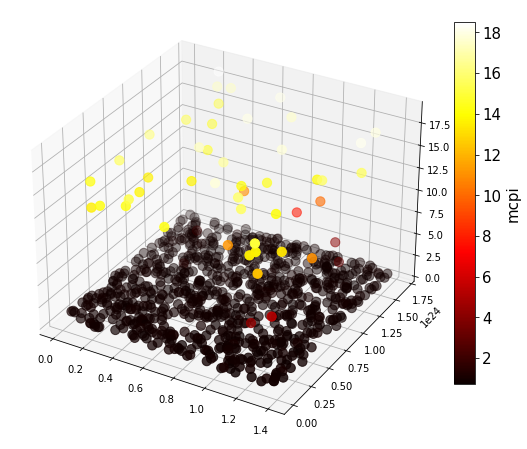

In [42]:
import matplotlib
from matplotlib import ticker

plt.figure(figsize=(16,9))
fig, axes = plt.subplots(1,1,figsize=(16,8),subplot_kw={'projection':"3d"}, squeeze=False)

#plt.scatter(vdis_list,beta_con_list,c=mcpi_list, s=80)
#plt.colorbar()

cmap = matplotlib.cm.get_cmap('magma')
print(cmap)
aa = axes[0][0].scatter3D(vdis_list,beta_con_list,mcpi_list, c=mcpi_list, s=85,cmap='hot')
#aa = axes.scatter3D(vdis_list,beta_con_list,mcpi_list, s=85,cmap=cmap)
add_common_colorbar(fig,aa,list(axes[0]),"mcpi",orientation='vertical',nbins=9,fontsize=15)


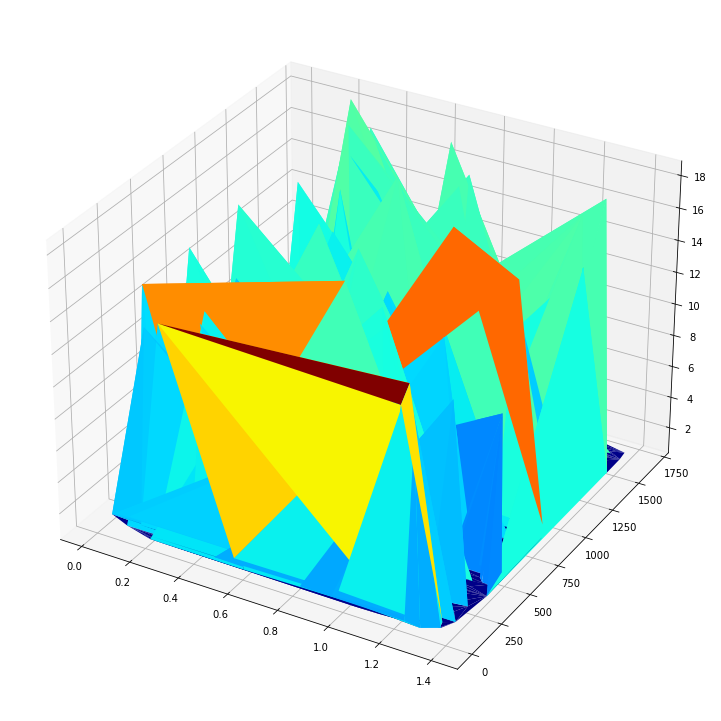

In [154]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,13))

surf = ax.plot_trisurf(np.array(vdis_list),np.array(beta_con_list)/10e20,np.array(mcpi_list),cmap=cm.jet)

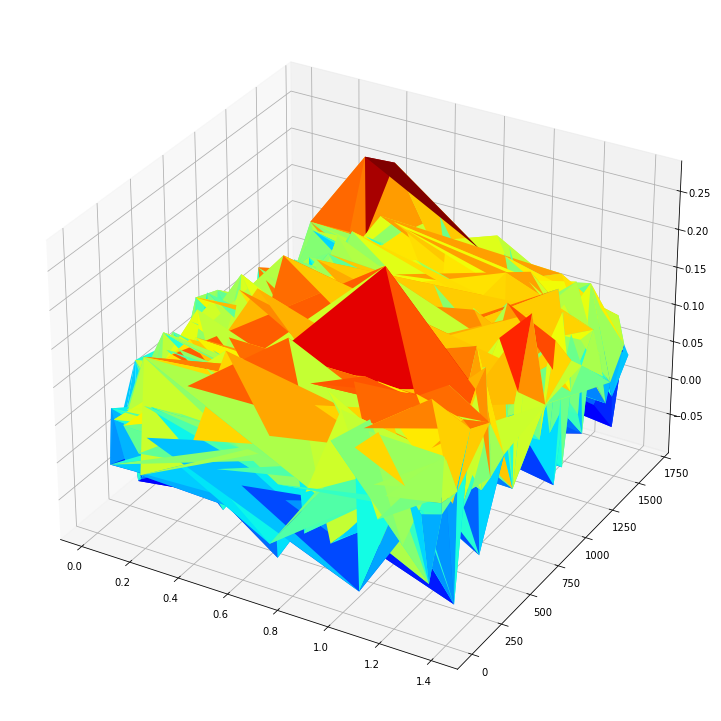

In [158]:
paras_pd_new = paras_pd[paras_pd.mcpi<1.1]

Xs = np.array(paras_pd_new.iloc[:,1])
Ys = np.array(paras_pd_new.iloc[:,2])
Zs = np.array(paras_pd_new.iloc[:,3])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,13))

surf = ax.plot_trisurf(Xs,Ys/10e20,1-Zs, linewidth=0,cmap=cm.jet)

In [48]:
from matplotlib import ticker
def add_common_colorbar(fig,im,axes,units,orientation='vertical',nbins=9,fontsize=15):
    '''
    Feb 12, 2021: generate a common colorbar for several specific subplots.
    For example, subplots on the same row or the same column.
    -----------------------
    Inputs:
    fig -- 
    im -- return handle. 
    axes --- the list for all subplots.
    units --- unit of colorbar.
    orientation --- direction of colorbar.
    nbins --- number of labeled ticks. default: 9
    fontsize --- label fontsize for colorbar. 
    '''
    pos1 = axes[-1].get_position() # get the original position for the last subplot 
    if orientation == 'vertical':
        pos2 = [pos1.x0 + pos1.width + 0.01, pos1.y0 + 0.1,  pos1.width / 20.0, pos1.height/1.2 ]   
    else:
        pos2 = [pos1.x0, pos1.y0 - 0.01, pos1.width, pos1.height / 25.0]
        
    cbar_ax = fig.add_axes(pos2)
    cb = fig.colorbar(im,ax=axes, orientation=orientation, cax=cbar_ax)
    cb.set_label(units,fontsize=fontsize)
    cb.ax.tick_params(labelsize=fontsize)
    tick_locator = ticker.MaxNLocator(nbins=nbins)
    cb.locator = tick_locator
    cb.update_ticks()

In [63]:
paras_pd

,case,vdis,beta_con,mcpi
0,case112,1.086555,1.028007e+23,0.986757
1,case134,0.024595,1.011225e+24,0.944964
2,case984,1.206095,9.026819e+23,0.866796
3,case105,0.162205,1.017905e+24,0.977691
4,case162,1.112965,4.367803e+23,0.888637
...,...,...,...,...
861,case614,1.032345,4.150717e+23,0.908447
862,case47,0.712645,5.770518e+23,0.932675
863,case516,0.562525,6.004303e+23,0.942240
864,case657,0.555575,9.577885e+23,0.888888


In [88]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

paras_pd_new = paras_pd[paras_pd.mcpi<2]

#X = preprocessing.normalize(paras_pd.iloc[:,1:3],norm='l2')
X = preprocessing.normalize(paras_pd_new.iloc[:,1:3])
X = np.array(paras_pd_new.iloc[:,1:3])
y = np.array(paras_pd_new.iloc[:,3])
print(X.shape,y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(817, 2) (817,)


0.0031559593311335558


(0.9, 1.0)

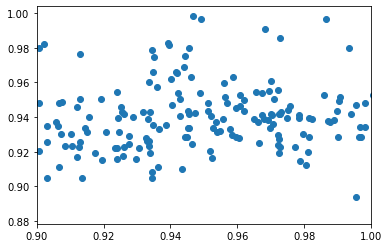

In [89]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

plt.scatter(y_test,y_pred)
plt.xlim(0.9,1)

0.0038257648190673024


(0.9, 1.0)

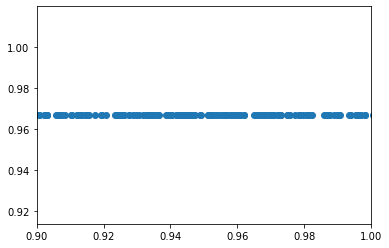

In [90]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
reg = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

plt.scatter(y_test,y_pred)
plt.xlim(0.9,1)

In [93]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
gp_kernel = ExpSineSquared(3.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
    + WhiteKernel(1e-1)
reg = GaussianProcessRegressor(kernel=gp_kernel)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

plt.scatter(y_test,y_pred)
plt.xlim(0.9,1)

LinAlgError: ("The kernel, ExpSineSquared(length_scale=3, periodicity=5) + WhiteKernel(noise_level=0.1), is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '5-th leading minor of the array is not positive definite')

[14:09:34] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
0.00395915642307555


(0.9, 1.0)

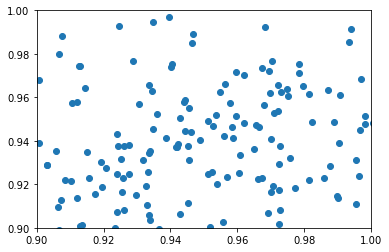

In [97]:
import xgboost as xgb
reg = xgb.XGBRegressor(objective ='reg:linear', n_estimators = 100, seed = 123) 

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

plt.scatter(y_test,y_pred)
plt.xlim(0.9,1)
plt.ylim(0.9,1)

0.003031035298769253


(0.9, 1.0)

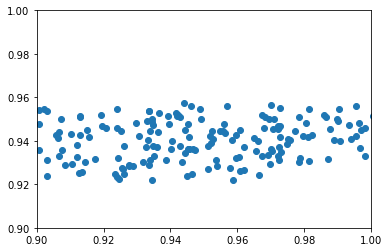

In [98]:
from sklearn.linear_model import HuberRegressor, Ridge
reg = Ridge(alpha=0.0, random_state=0, normalize=True)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

plt.scatter(y_test,y_pred)
plt.xlim(0.9,1)
plt.ylim(0.9,1)

In [188]:
import skccm.data as data

rx1 = 3.72 #determines chaotic behavior of the x1 series
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = 0.2 #Influence of x1 on x2
b21 = 0.01 #Influence of x2 on x1
ts_length = 1000
x1,x2 = data.coupled_logistic(rx1,rx2,b12,b21,ts_length)

print(x1.shape)
print(x2.shape)

(1000,)
(1000,)


In [196]:
import skccm as ccm
lag = 1
embed = 2
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

print(X1.shape)

(999, 2)


In [197]:
from skccm.utilities import train_test_split

#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

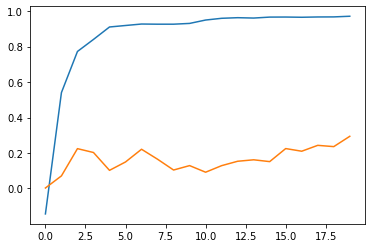

In [198]:
plt.plot(sc1)
plt.plot(sc2)

# scam sensitivity 

In [17]:
all_cases = os.listdir("/S2/gscr2/tzhang/big_data/UQ/scam_sampling/")
all_cases_data = pd.DataFrame(columns=['zmconv_c0_lnd','LWCF','SWCF','PRECT'])

for case in all_cases:
    fp = open("/S2/gscr2/tzhang/big_data/UQ/scam_sampling/"+case+"/atm_in")
    for i, line in enumerate(fp):
        if i == 198:
            zmconv_c0_lnd = float(line.split('=')[1])
    fp.close()

    
    fp1 = Dataset("/S2/gscr2/tzhang/big_data/UQ/scam_sampling/"+case+"/camrun.cam.h1.1995-07-19-00000.nc")
    
    LWCF = np.mean(fp1.variables['LWCF'][:])
    SWCF = np.mean(fp1.variables['SWCF'][:])
    PRECT = np.mean(fp1.variables['PRECT'][:])
    
    all_cases_data = all_cases_data.append({'zmconv_c0_lnd':zmconv_c0_lnd,'LWCF':LWCF,'SWCF':SWCF,'PRECT':PRECT},ignore_index=True)

In [18]:
all_cases_data

,zmconv_c0_lnd,LWCF,SWCF,PRECT
0,0.007759,39.964584,-73.288521,7.415466e-08
1,0.005517,43.118011,-77.570061,7.483060e-08
2,0.007110,41.032604,-72.954201,7.529356e-08
3,0.005635,41.189339,-76.062637,7.458356e-08
4,0.005812,41.963989,-77.687828,7.409048e-08
...,...,...,...,...
95,0.006343,41.327805,-77.603516,7.392188e-08
96,0.007818,39.782448,-71.990326,7.445359e-08
97,0.006402,40.873253,-74.596146,7.499515e-08
98,0.004219,45.499454,-82.572685,7.459415e-08


In [20]:
all_cases_data.to_csv("scam_c0_lnd_sa.csv")